<a href="https://colab.research.google.com/github/stranger-1-1-13/outfit_recommendation_system/blob/main/outfit_reco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q opendatasets
!pip install tensorflow
!pip install streamlit

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small') # insert ypu kaggle  username and key


Skipping, found downloaded files in "./fashion-product-images-small" (use force=True to force download)


In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [27]:
DATASET_PATH = "/content/fashion-product-images-small/myntradataset"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [34]:
df = pd.read_csv( '/content/fashion-product-images-small/myntradataset/styles.csv', nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(11)

<ipython-input-34-b8f4ee34d2bb>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv( '/content/fashion-product-images-small/myntradataset/styles.csv', nrows=5000, error_bad_lines=False)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [35]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

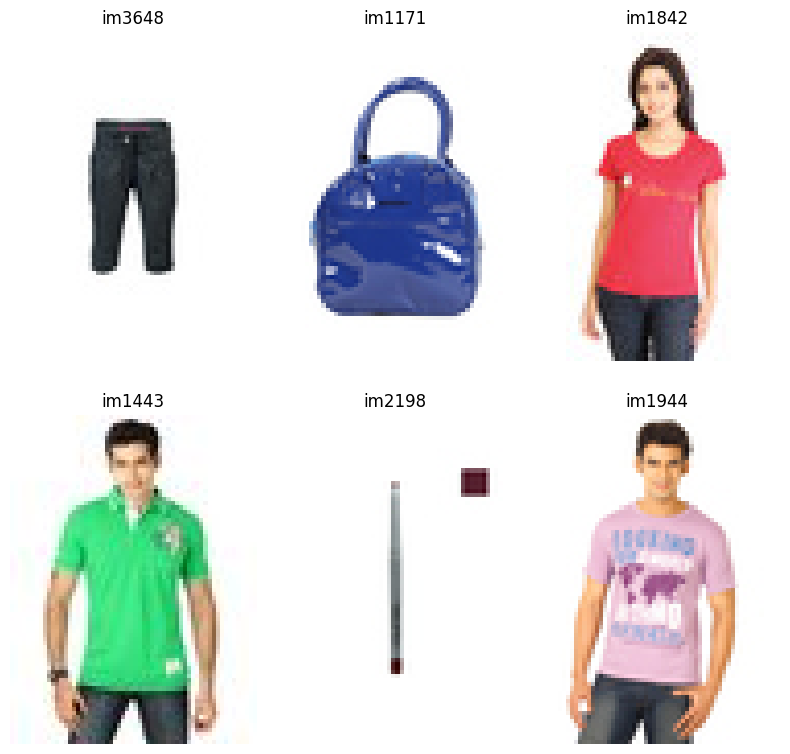

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

<Axes: >

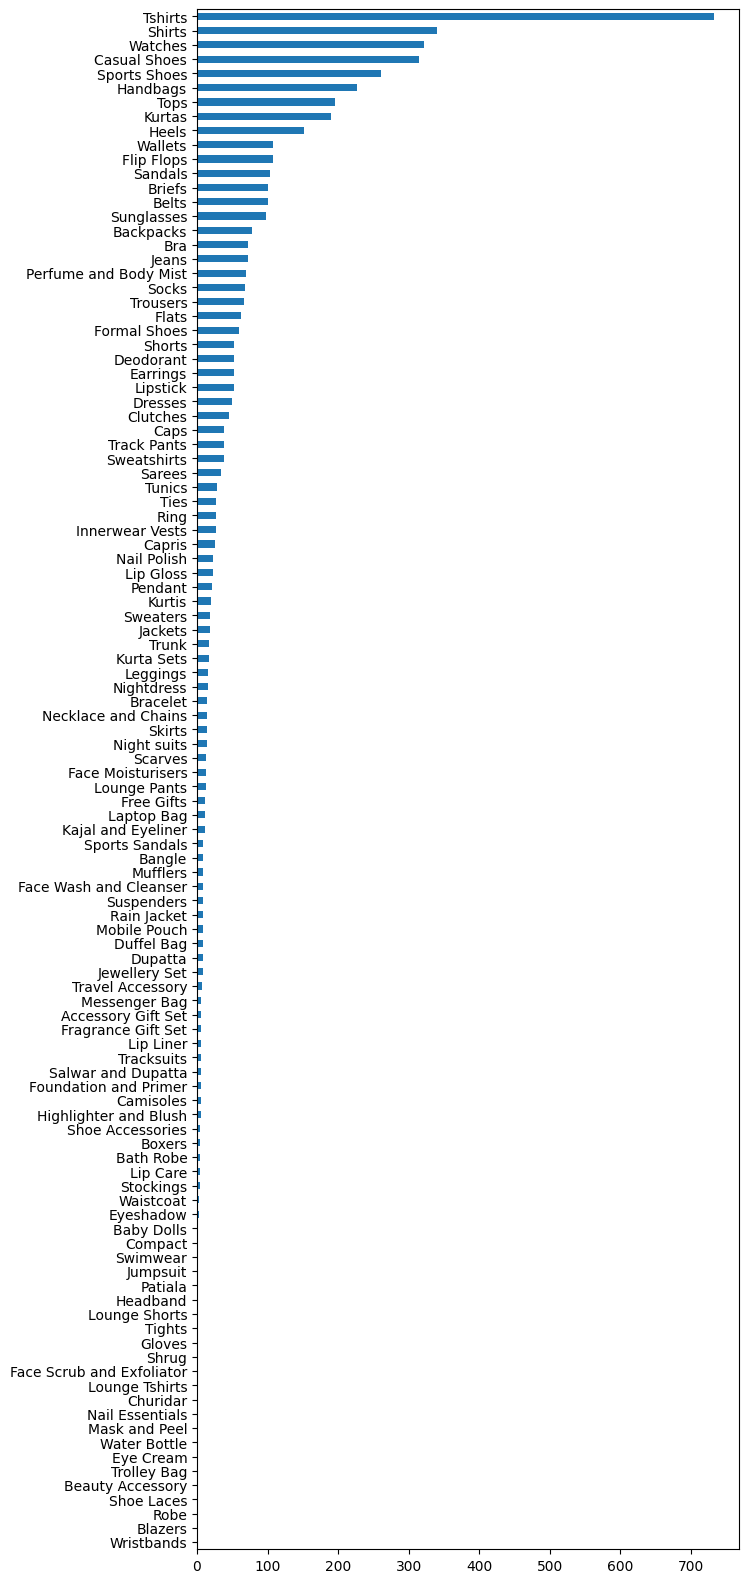

In [37]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [38]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.15.0'

In [39]:
# Input Shape
img_width, img_height, _ = load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [40]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [41]:
emb = get_embedding(model, df.iloc[1].image)
emb.shape

1/1 [==============================] - 1s 1s/step


(2048,)

[1.8793392 1.6008786 0.0920288 ... 3.268899  2.2717319 5.4333835]


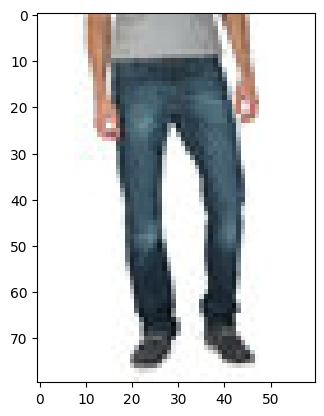

In [42]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[1].image), cv2.COLOR_BGR2RGB))
print(emb)

In [59]:
%%time
!pip install swifter


import swifter

# Parallel apply
map_embeddings = df['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 76ms/step
(5000, 2048)
CPU times: user 12min 50s, sys: 18 s, total: 13min 8s
Wall time: 13min 31s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.651427,0.000000,0.752223,0.000000,0.000000,4.103797,2.382158,2.472525,0.0,...,0.366396,0.000000,0.000000,6.000697,0.000000,0.000000,6.389911,4.246408,1.067720,1.671668
1,1.879339,1.600879,0.092029,4.433077,0.000000,0.000000,3.030765,8.530592,5.498660,0.0,...,2.808286,0.000000,3.923480,3.183104,0.000000,0.000000,4.244198,3.268899,2.271732,5.433383
2,0.000000,0.311199,0.000000,3.808684,0.437028,7.112503,0.000000,0.000000,0.000000,0.0,...,0.218205,7.861305,1.655930,0.000000,0.000000,0.000000,4.703021,0.000000,2.340580,0.000000
3,0.588021,9.894620,0.000000,6.295309,1.783730,1.913129,0.000000,13.309938,7.805779,0.0,...,22.434381,0.000000,0.000000,0.000000,2.565927,3.330475,0.594363,1.130465,3.084232,7.608930
4,0.000000,1.882977,0.000000,5.122101,0.000000,0.000000,2.950287,6.626863,1.606635,0.0,...,2.504945,0.000000,1.274127,3.484576,0.786349,0.000000,1.597855,2.515499,0.068349,0.000000


In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.57894295, 0.23815566, 0.49101055],
       [0.57894295, 0.9999994 , 0.23951334, 0.72273505],
       [0.23815566, 0.23951334, 1.        , 0.22011644],
       [0.49101055, 0.72273505, 0.22011644, 1.        ]], dtype=float32)

In [61]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]

    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([259, 4305, 0, 2779, 2701], dtype='int64'),
 [0.90718955, 0.8946354, 0.89189005, 0.88897973, 0.88077515])

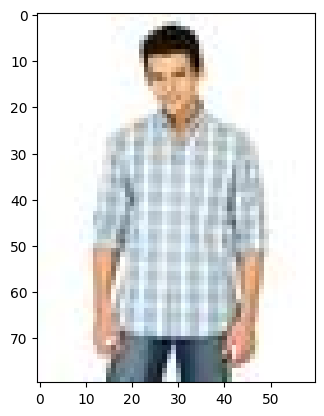

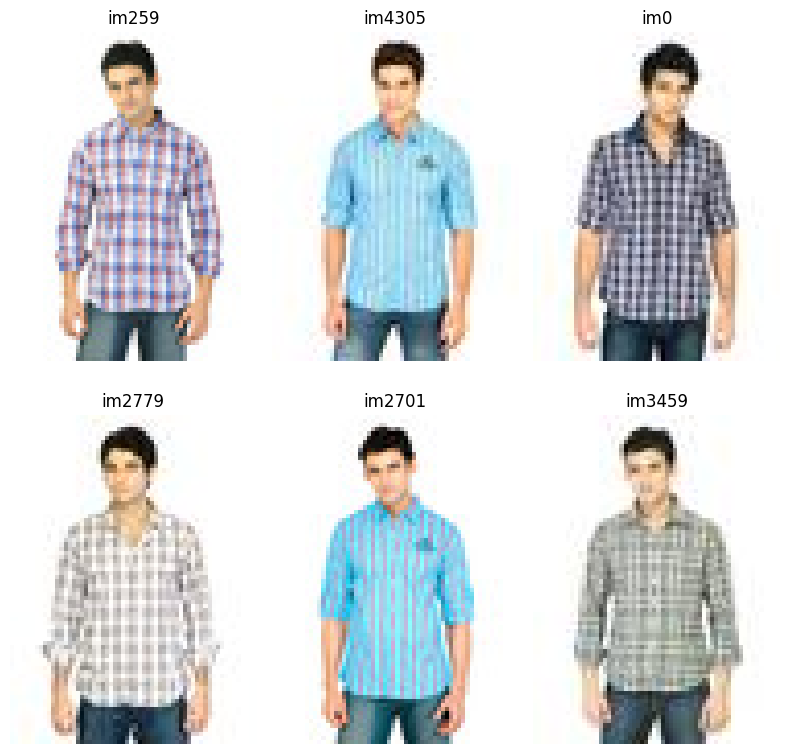

In [62]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)


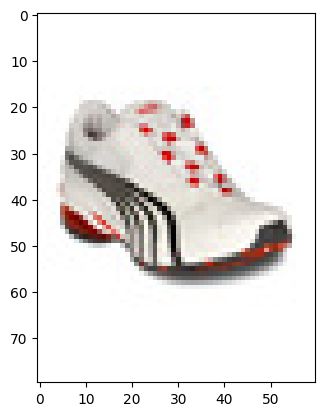

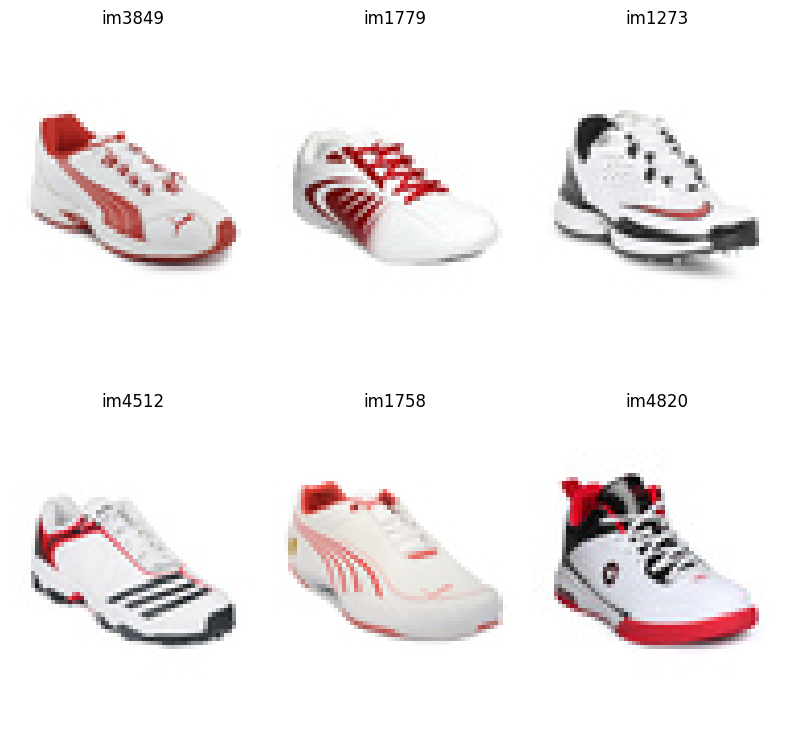

In [63]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [64]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [65]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [66]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 17.42608380317688 seconds


In [67]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

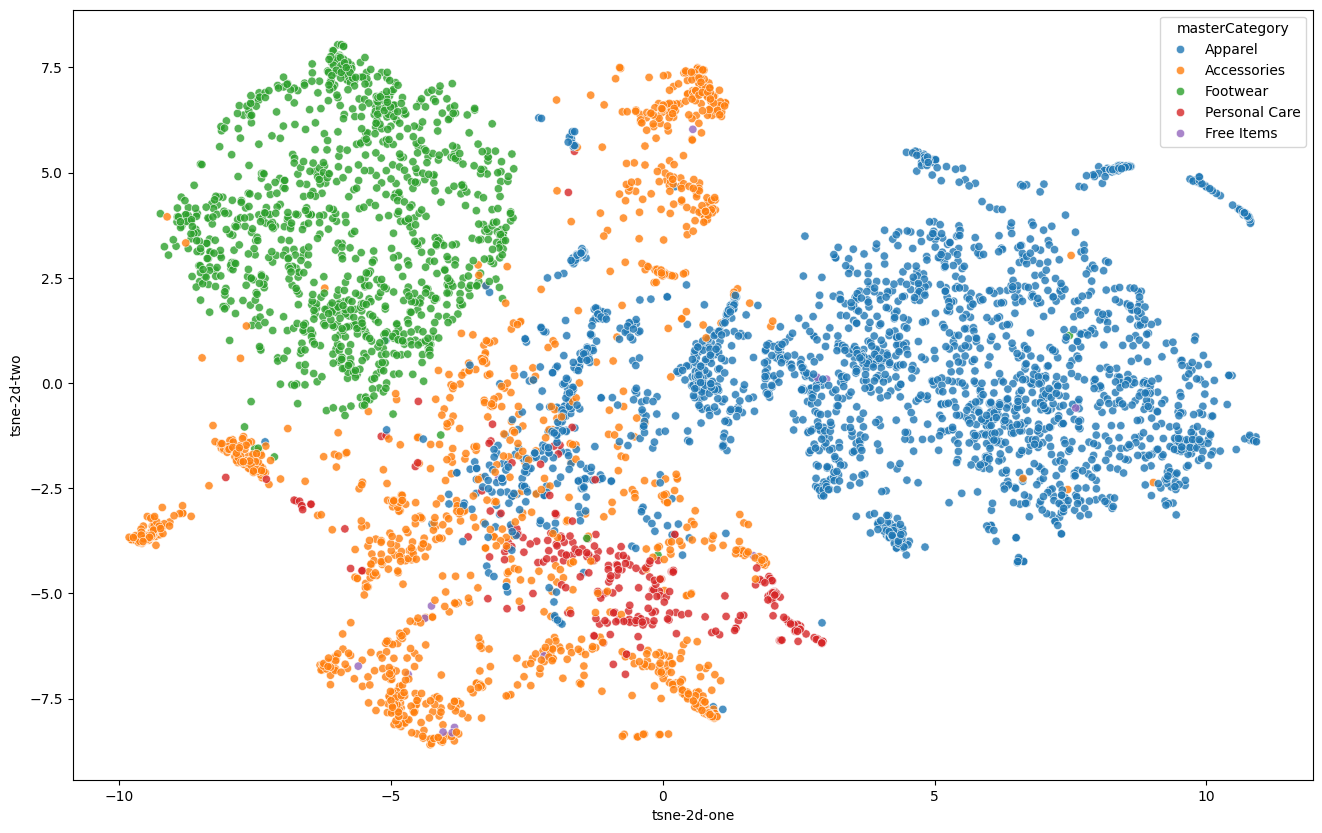

In [68]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

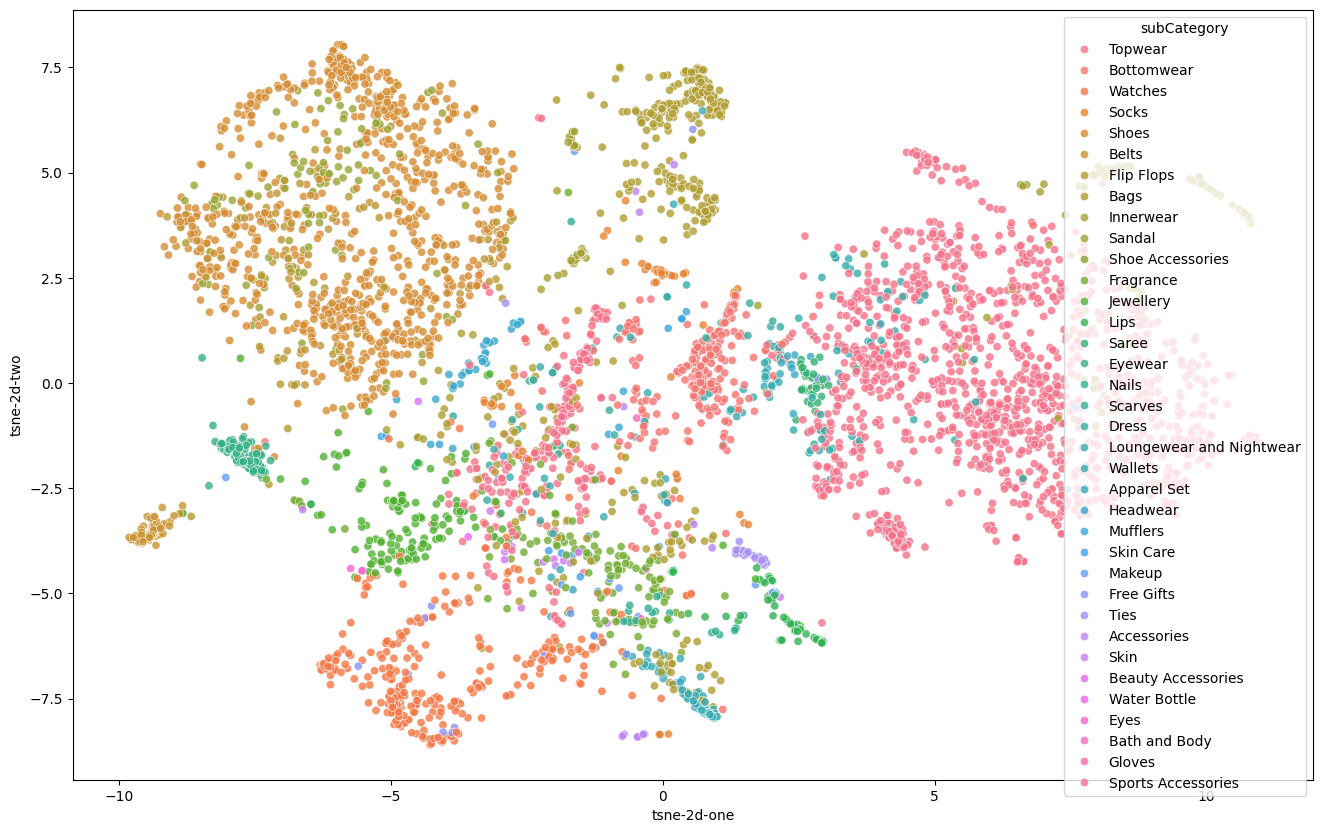

In [69]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [71]:
df.sample(100).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')